<a href="https://colab.research.google.com/github/ghr8635/E2E-DriveAI-ROS2-based-Modular-Framework-for-Autonomous-Vehicle-Control/blob/main/self_built_point_pillar_architecture_(simple_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install open3d


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

**Define the PointPillars Feature Extraction Model**

In [4]:
class PillarFeatureEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_points_per_pillar, grid_x, grid_y):
        super(PillarFeatureEncoder, self).__init__()
        self.num_points_per_pillar = num_points_per_pillar
        self.grid_x, self.grid_y = grid_x, grid_y
        # Simple linear layer to encode pillar features
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, pillars):
        # Flatten and encode features
        pillars = self.fc(pillars)  # Shape: (batch, grid_x, grid_y, num_points, out_channels)
        return pillars.mean(dim=2)  # Reduce across point dimension to get (batch, grid_x, grid_y, out_channels)

class BackboneNetwork(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BackboneNetwork, self).__init__()
        # Simple 2D CNN layers for feature extraction
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # Shape: (batch, out_channels, grid_x//4, grid_y//4)
        return x

class PointPillarsFeatureExtractor(nn.Module):
    def __init__(self, in_channels=4, out_channels=256, num_points_per_pillar=32, grid_x=100, grid_y=100):
        super(PointPillarsFeatureExtractor, self).__init__()
        self.pfe = PillarFeatureEncoder(in_channels, out_channels, num_points_per_pillar, grid_x, grid_y)
        self.backbone = BackboneNetwork(out_channels, out_channels)

    def forward(self, x):
        pillar_features = self.pfe(x)  # Shape: (batch, grid_x, grid_y, out_channels)
        pillar_features = pillar_features.permute(0, 3, 1, 2)  # Shape: (batch, out_channels, grid_x, grid_y)
        feature_map = self.backbone(pillar_features)
        return feature_map

**Prepare a Simple Dataset for Training which mimics pcd data**

In [5]:
class SyntheticPointCloudDataset(Dataset):
    def __init__(self, num_samples, grid_x=100, grid_y=100, num_points_per_pillar=32, in_channels=4):
        self.num_samples = num_samples
        self.grid_x, self.grid_y = grid_x, grid_y
        self.num_points_per_pillar = num_points_per_pillar
        self.in_channels = in_channels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random pillars with shape: (grid_x, grid_y, num_points, in_channels)
        pillars = np.random.rand(self.grid_x, self.grid_y, self.num_points_per_pillar, self.in_channels).astype(np.float32)
        return torch.tensor(pillars)

# Parameters
num_samples = 100
dataset = SyntheticPointCloudDataset(num_samples)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


**Training Loop (Optional, to learn feature extraction patterns)**

In [6]:
# Instantiate model, optimizer, and criterion
model = PointPillarsFeatureExtractor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Simple Training Loop
epochs = 5
for epoch in range(epochs):
    for batch_idx, pillars in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        features = model(pillars)  # Extracted features, shape: (batch, out_channels, grid_x//4, grid_y//4)

        # Dummy target: here we're using the output itself as target for demonstration
        target = features.clone().detach()  # This is just for illustrative purposes
        loss = criterion(features, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")


KeyboardInterrupt: 

**Saving Model**

In [ ]:
# Define the file path where you want to save the model
model_save_path = "/content/drive/MyDrive/ROS2-Modular-Framework-for-End-to-End-Autonomous-Vehicle-Control-from-Raw-Sensor-Data/self_built_point_pillar.pth"

# After training is complete, save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/ROS2-Modular-Framework-for-End-to-End-Autonomous-Vehicle-Control-from-Raw-Sensor-Data/self_built_point_pillar.pth


**Note: Upto this point the point pillar based feature extracting model is trained with simply generated dataset and saved. The next part is for inference where a pcd file is processed and provided to the model for inference.**

In [7]:
import open3d as o3d
import numpy as np

def load_pcd(pcd_file):
    pcd = o3d.io.read_point_cloud(pcd_file)
    points = np.asarray(pcd.points)
    print(f"Loaded points: {points.shape}")
    return points

# Load the PCD file
pcd = r"C:\Users\hussa\OneDrive\Desktop\Projects\Project\MOT\INFRA-3DRC_scene-15\INFRA-3DRC_scene-15\lidar_01\lidar_01__data\lidar_01__2023-06-02-21-28-13-721.pcd"


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
import numpy as np

def preprocess_point_cloud(points, grid_x, grid_y, voxel_size=0.1):
    """
    Convert 3D point cloud to pillar representation.
    """
    # Check if the points are loaded correctly
    print(f"Number of points: {points.shape[0]}")

    # Check if points are within the expected range
    x_min, y_min = np.min(points[:, 0]), np.min(points[:, 1])
    x_max, y_max = np.max(points[:, 0]), np.max(points[:, 1])
    print(f"x range: ({x_min}, {x_max}), y range: ({y_min}, {y_max})")

    # Create grid for the 2D space
    grid_x_range = np.linspace(x_min, x_max, grid_x)
    grid_y_range = np.linspace(y_min, y_max, grid_y)

    # Initialize pillar features
    pillars = np.zeros((grid_x, grid_y, 32, 4))  # (grid_x, grid_y, max_points_per_pillar, feature_dim)

    for point in points:
        # Calculate the 2D grid coordinates for the point
        x_idx = int((point[0] - x_min) / voxel_size)
        y_idx = int((point[1] - y_min) / voxel_size)

        # Ensure indices are within the grid bounds
        x_idx = min(x_idx, grid_x - 1)
        y_idx = min(y_idx, grid_y - 1)

        #print(f"Grid coordinates for point {point}: ({x_idx}, {y_idx})")

        # Add the point features (x, y, z, intensity) to the pillar
        pillar = pillars[x_idx, y_idx]

        # If there is an empty space in the pillar (0 entries), insert the point
        empty_slot_idx = np.where(np.all(pillar == 0, axis=1))[0]

        if len(empty_slot_idx) > 0:
            # Fill the first empty slot (use the first one)
            pillar_idx = empty_slot_idx[0]
            pillars[x_idx, y_idx, pillar_idx] = np.append(point, 1)  # Add intensity as 1 for now
        else:
            # If no empty slots, replace the point in the pillar (you could add a logic to choose the best point)
            pillar_idx = np.argmin(np.linalg.norm(pillar[:, :3], axis=1))  # Choose the point closest to the origin of the pillar
            pillars[x_idx, y_idx, pillar_idx] = np.append(point, 1)  # Replace with the new point's features

    return pillars

points = load_pcd(pcd)
preprocessed_pillars = preprocess_point_cloud(points, grid_x=100, grid_y=100)
print(preprocessed_pillars.shape)



Loaded points: (65536, 3)
Number of points: 65536
x range: (-180.619140625, 121.57653045654297), y range: (-66.9447250366211, 108.28617858886719)
(100, 100, 32, 4)


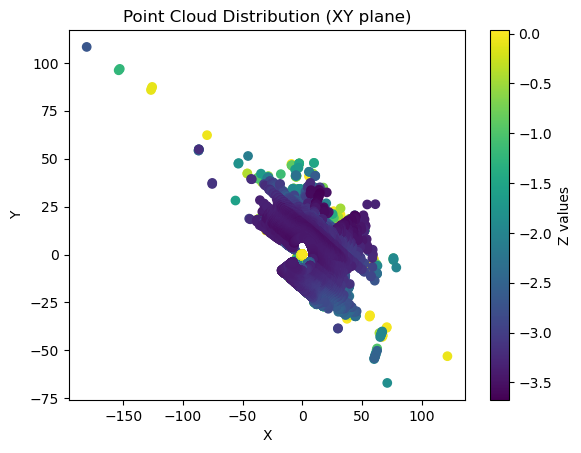

In [9]:
import matplotlib.pyplot as plt

# Visualize the x-y distribution of the points
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis')
plt.colorbar(label='Z values')
plt.title('Point Cloud Distribution (XY plane)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


**Loading the Model for Inference**

In [11]:
import torch

# Initialize the model (assuming you already have the model architecture and weights loaded)
model = PointPillarsFeatureExtractor()

# Load the saved weights
model_save_path = 'self_built_point_pillar.pth'
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

# Convert the preprocessed point cloud into a torch tensor
input_tensor = torch.tensor(preprocessed_pillars, dtype=torch.float32).unsqueeze(0)  # Add batch dimension


print(input_tensor.shape)

# Perform inference (no gradient calculation since we're not training)
with torch.no_grad():
    feature_map = model(input_tensor)

# Process the feature_map for your task (if needed)
print("Feature map extracted:")
print(feature_map.shape)  # Check the output shape
print(feature_map)


torch.Size([1, 100, 100, 32, 4])
Feature map extracted:
torch.Size([1, 256, 25, 8])
tensor([[[[-0.0260, -0.0147, -0.0174,  ..., -0.0174, -0.0174, -0.0196],
          [-0.0165, -0.0124, -0.0136,  ..., -0.0136, -0.0136, -0.0155],
          [-0.0148, -0.0136, -0.0136,  ..., -0.0136, -0.0136, -0.0155],
          ...,
          [-0.0148, -0.0136, -0.0136,  ..., -0.0136, -0.0136, -0.0155],
          [-0.0148, -0.0136, -0.0136,  ..., -0.0136, -0.0136, -0.0155],
          [-0.0095, -0.0235, -0.0281,  ..., -0.0168, -0.0096, -0.0077]],

         [[-0.0354, -0.0397, -0.0424,  ..., -0.0424, -0.0424, -0.0412],
          [-0.0402, -0.0768, -0.0744,  ..., -0.0744, -0.0744, -0.0710],
          [-0.0414, -0.0744, -0.0744,  ..., -0.0744, -0.0744, -0.0710],
          ...,
          [-0.0414, -0.0744, -0.0744,  ..., -0.0744, -0.0744, -0.0710],
          [-0.0414, -0.0744, -0.0744,  ..., -0.0744, -0.0744, -0.0710],
          [-0.0369, -0.0702, -0.0704,  ..., -0.0755, -0.0775, -0.0630]],

         [[ 0.0161